In [1]:
import xarray as xr
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

In [2]:
DATA_DIR = '/local/S.Rasp/ML-Workshop-Data/dataset2/'

In [4]:
!ls $DATA_DIR

forecast_errors.png  nwp_ecmwf-ifs.nc	power_curve_single_turbine.png
metobs.nc	     nwp_envca-gdps.nc	README.md
ml_workshop_data.7z  nwp_ncep-gfs4.nc	windpark.nc


In [5]:
def fill_forecasts(ds, field, dtidx, fc_begin_h=0, fc_end_h=48, fc_resolution_h=3):
    """Return an array containing one forecast per timestamp provided. fc_resolution is given in hours
    and is a property of the model, i.e. should actually be avalable from the .nc file."""
    result = np.empty([len(dtidx), 1 + (fc_end_h - fc_begin_h) // fc_resolution_h])
    fc_begin = fc_begin_h * 3600
    fc_end = fc_end_h * 3600
    fc_resolution = fc_resolution_h * 3600
    last_forecast = None

    for i, dt in enumerate(dtidx):
        # the following will break if the forecast envelope in the input file is exceeded
        if np.any(ds.epoch_s == dt):   # ?? why not  dt in ds.epoch_s  ??
            result[i, :] = ds[field].loc[dt, fc_begin:fc_end]
            last_forecast = dt
        else:
            fc_offset = dt - last_forecast
            result[i, :] = ds[field].loc[last_forecast, (fc_begin + fc_offset):(fc_end + fc_offset)]
            
    return result

In [6]:
def get_obs_array(ds, field, dtidx, rel_begin_m=0, rel_end_m=48, obs_resolution_m=15):
    """Return an array containing the observations around each timestamp in the index.
    The resolution of the input timeseries must be known and the timeseries must be regular."""
    result = np.empty([len(dtidx), 1 + (rel_end_m - rel_begin_m) // obs_resolution_m])
    rel_begin = rel_begin_m * 60
    rel_end = rel_end_m * 60
    obs_resolution = obs_resolution_m * 60
    for i, dt in enumerate(dtidx):
        result[i, :] = ds[field].loc[(dt + rel_begin):(dt + rel_end)]
    return result

In [7]:
# assemble a big forecast array by iterating over all models
ts_beg = '2016-01-01'  # from 2015-01-01   # FIXME use full range for training and/or separate test set
ts_end = '2016-02-01'  # up to 2016-10-18
pattern_step_h = 3  # generate one training pattern every this many hours
fc_begin_h, fc_end_h = 0, 30  # the (inclusive) forecast range in hours
obs_begin_m, obs_end_m = -720, 345  # the (inclusive) observation range in min
targ_begin_m, targ_end_m = 360, 1440  # the (inclusive) target range in min
# models and fields to be considered (here: just an example, should of course be more comprehensive)
models_used = {
    'ncep-gfs4': ['ws10m', 'ws100m'],
    'envca-gdps': ['ws1000mb', 'q']
    }
obs_fields = ['ws80m']
target = 'power'

In [8]:
epo_idx = range(np.datetime64(ts_beg, 's').astype(int), 
               np.datetime64(ts_end, 's').astype(int),
               pattern_step_h * 3600) 
input_patterns = []

In [10]:
epo_idx[3]

1451638800

In [12]:
# append all models
for model, fields in models_used.items():
    xdat = xr.open_dataset(f'{DATA_DIR}/nwp_%s.nc' % model)
    for field in fields:
        input_patterns.append(fill_forecasts(xdat, field, epo_idx, fc_begin_h=fc_begin_h, fc_end_h=fc_end_h))

In [14]:
len(input_patterns), input_patterns[0].shape

(4, (248, 11))

In [15]:
print(input_patterns[-2].shape, input_patterns[-1].shape)

(248, 11) (248, 11)


In [16]:
input_patterns = np.hstack(input_patterns)
print(input_patterns.shape)

(248, 44)


In [18]:
# construct corresponding targets
xdat = xr.open_dataset(f'{DATA_DIR}/windpark.nc')
# FIXME: Need to make the time index regular at this point!
#        Missing data need to be set to NaN. Resolution could be reduced to hourly averages.
target_patterns = get_obs_array(xdat, target, epo_idx, rel_begin_m=targ_begin_m, rel_end_m=targ_end_m, obs_resolution_m=10)

In [20]:
target_patterns.shape

(248, 109)

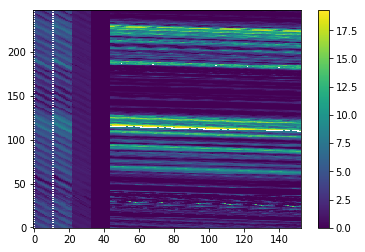

In [21]:
plt.imshow(np.hstack([input_patterns, target_patterns*20]), aspect='auto', origin='lower')
plt.colorbar()
plt.show()

Text(0.5,0,'Steps in 10 mins')

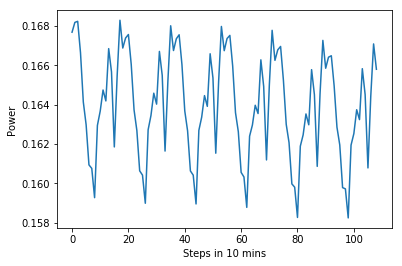

In [26]:
plt.plot(np.nanmean(target_patterns, 0))
plt.ylabel('Power')
plt.xlabel('Steps in 10 mins')

In [25]:
109/6

18.166666666666668